# Reinforcement Learning Task

Here we'll also define a few parameters, one of which, gamma, will determine how much future prizes are discounted
by the passage of time, thereby influencing "how many moves before winning or losing" we award in the future. 
Soon, we'll have a more in-depth chat about this.

In [1]:


import numpy as np
import gym
# gym initialization
env = gym.make('Pong-v0')
observation = env.reset()
prev_input = None
# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3
# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99
# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0


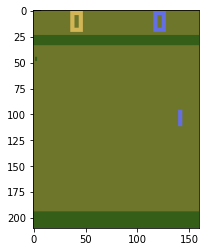

In [2]:
#using the pyplot tool, let's have a look at the Pong a frame, the most fundamental data unit in the context of the game.
#In this mode, our own policy model will replace OpenAI's Pong AIs, which power the game's agents.

import matplotlib.pyplot as plt
env = gym.make('Pong-v0') # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(22):
 
 if i > 20:
     plt.imshow(observation)
     plt.show()
     observation, _, _, _ = env.step(1)


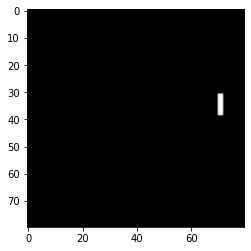

In [5]:
#We could keep plotting more frames to watch the game's flow by adjusting the range of the loop, but for now we'll forego that.
#It's important to keep in mind that the OpenAI gym environment handles tracking incentives internally, 
#so this frame doesn't need to provide that information. To prepare our frame for a one-dimensional neural network,
# we'll crop it and grayscale it before flattening the output.

def pre_process(I):
# prepro 210x160x3 frame into 6400 (80x80) 1D float vector
 I = I[35:195] # crop
 I = I[::2,::2,0] # downsample by factor of 2
 I[I == 144] = 0 # erase background (background type 1)
 I[I == 109] = 0 # erase background (background type 2)
 I[I != 0] = 1 # everything else (paddles, ball) just set to 1
 return I.astype(float).ravel()
#Show
preprocessedobs_preprocessed = pre_process(observation).reshape(80,80)
plt.imshow(preprocessedobs_preprocessed, cmap='gray')
plt.show()





In [6]:
#we can include a discount function that uses a decay rate (gamma, defined above) 
#to split the normalized earned reward among the preceding frames:

def dis_rewards(r, gamma):
#take 1D float array of rewards and compute discounted reward
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset 
        running_add = running_add * gamma + r[t] 
        discounted_r[t] = running_add
    discounted_r -= np.mean(discounted_r) #normalizing the result
    discounted_r /= np.std(discounted_r) #idem using standar deviation
    return discounted_r



In [7]:
#Now that we know what we're working with, we can define our model as a two-layer, densely-connected structure. 
#Our images are pixel-based, thus they can be represented by 1D arrays, making them suitable for a fully-connected neural network.
# However, convolutional models are also conceivable (and have considerably fewer parameters).

import keras
from tensorflow.keras.layers import Input
from keras.optimizers import Adam 
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.models import Sequential

model = Sequential()
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1280200   
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Now that we have the model, we can start putting it through its paces in network training. 
#To kick off the data gathering procedure, let's first use the aforementioned preprocessing method to ready our inputs. 
#Then, the current network is fed our input and an action, signifying an upward or downward translation, is predicted. 
#Our datasets are then ready for training after we have appended our x and y variables. 
#The Pong environment also takes in information about our activities and uses it to calculate and save a reward score.

history = []
observation = env.reset()
prev_input = None
while (True):
 cur_input = pre_process(observation)
 
 x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
 prev_input = cur_input 
 proba = model.predict(np.expand_dims(x, axis=1).T)
 action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
 y = 1 if action == 2 else 0 
x_train.append(x)
y_train.append(y)
observation, reward, done, info = env.step(action)
rewards.append(reward)
reward_sum += reward


In [13]:
#If done

history.append(reward_sum)
print(‘At the end of episode’, episode_nb, ‘the total reward was :’, reward_sum)
if episode_nb>=3000 and reward_sum >=-12:
break
else:
episode_nb += 1

# training
model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=dis_rewards(rewards, gamma))


# Reinitialization
x_train, y_train, rewards = [],[],[]
observation = env.reset()
reward_sum = 0
prev_input = None
plt.plot(history)
plt.show()
